In [87]:
IMAGES = "./images/" # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination

# Clean up for your vacation images

In [88]:
import glob
import os
import shutil
import matplotlib.pyplot as plt
#import seaborn as sb
%matplotlib inline

import pandas as pd
import cv2
import numpy as np

In [89]:
def split_filepath(file, split=False):
    """
    Function to split file from path and return either of them.
    
    parameters:
        file: (str), full path to file
        split: (bool), flag, if path shall be returned
        
    """
    file = file.replace('\\', '/')
    if split is True:
        if os.path.isfile(file):
            _ = file.split('/')
            return '/'.join(_[:-2]), _[-1]
        else:
            if os.path.exists(file):
                if file[-1] is not '/':
                    file = file + '/'
                return file
            else:
                print('The file/path {} does not exist.'.format(file))
    else:
        return file
        
def read_files(path, ext):
    """
    Function to read image filenames from a directory and their creation date.
    
    parameters:
        path: (str), filename
        ext: (str), extension for files to be considered
    """
    files = glob.glob('{}*.{}'.format(path, ext))
    # file modification date seems to be more reliable
    files = [(split_filepath(f, split=True)[-1], os.stat(f).st_mtime) for f in files]
    #files = [(split_filepath(f, split=True)[-1], os.path.getctime(f)) for f in files] 
    return files

def read_img(file, read_type=None):
    """
    Function to read images.
    
    parametsr:
        file: (str), filename
        read_type: (str), different opencv conversions of images
    
    """
    if read_type == None:
        return cv2.imread(file)
    elif read_type == 'hsv':
        return cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2HSV)
    elif read_type == 'gray':
        return cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)

def resize_img(img, scale=0.05):
    """
    Resizing function.
    
    parameters:
        img: (array), image
        scale: (float), factor used for reduction (1.0 means no change)
    """
    x, y = int(img.shape[0]*scale), int(img.shape[1]*scale)
    return cv2.resize(img, (y, x))

# How many Correlations exist between images?

Text(0, 0.5, 'number of calculations')

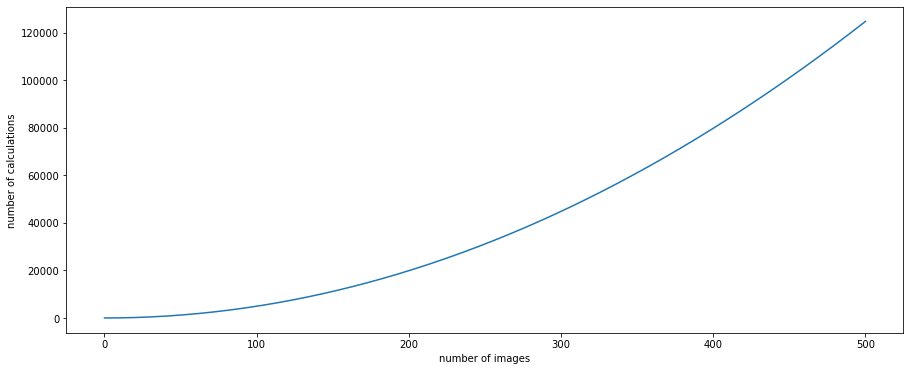

In [90]:
# function increases steeply, thus we make the assumption that only adjacent images are related to each other
def corr(n):
    return n*(n-1)/2

n = np.linspace(0, 500)
plt.figure(figsize=(15, 6))
plt.plot(n, corr(n))
plt.xlabel('number of images')
plt.ylabel('number of calculations')

# Pipeline

In [91]:
# Load images meta data

dict_files = read_files(path=IMAGES, ext='jpg')
df = pd.DataFrame(dict_files, columns=['File', 'Creation_Date'])
df['Creation_Date'] = pd.to_numeric(df['Creation_Date'], downcast='integer')
df = df.sort_values(by=['Creation_Date'])
df['Timediff'] = df['Creation_Date'].diff(-1).abs()
df.head()

,File,Creation_Date,Timediff
0,ac_0.JPG,1561815246,26.0
1,ad_0.JPG,1561815272,12.0
2,ae_0.JPG,1561815284,6.0
3,ae_1.JPG,1561815290,96.0
4,af_0.JPG,1561815386,134.0


In [92]:
# assign labels

df = df.assign(Target = df['File'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['Target'], _ = pd.factorize(df['Target'])

In [93]:
# define scoring metric (will be later used to compare different groupings)

labels = df['Target'].copy()
n_img = len(labels.unique())
    
def loss_function(pred, n_img=None):
    """
    Loss function for ranking evaluation. Has two contributions:
    * MSE estimate, if the ranking yields more groups than actually exist (unproblematic)
    * a polynomial penalty, if the ranking groups together images of different classes (problematic,
        since images might get lost)
    
    Returns a tuple: (number of images found, loss value (min value = 1))
    
    parameters:
        pred = (list, array), label predictions
        n_img = (int), true number of groups
    
    """
    def penalty(x):
        return np.sum(x**3)
    
    # 1. MSE estimate
    mse = np.sum((labels - pred) ** 2)
    
    # 2. error for missed images
    df = pd.DataFrame(np.c_[labels, pred], columns=['labels', 'pred'])
    df_grouped = df.groupby(['pred'])['labels'].apply(lambda x: len(set(x))).to_frame()
    miss_loss = penalty(df_grouped['labels'].values)
    
    # 3. images found
    img_found = min(n_img, len(set(df_grouped.index[df_grouped['labels']==1].values)))
    
    miss_loss /= max(1, img_found)
    mse /= max(1, img_found)    
    return img_found, mse + miss_loss

In [94]:
# example output 

loss_function(labels, n_img)

(15, 1.0)

# Rank images by time difference

In [95]:
def timelag_ranker(series, max_lag=10, max_per_group=4):
    """
    Ranker function, distinguishes images based on difference timestamps.
    
    parameters:
        max_lag = (float), seconds between images
        group_default = (int), maximum number of images per group
    """
    rank = 0
    n_group = 0
    for i in range(len(series)-1):
        yield rank
        n_group += 1
        if series.loc[i] > max_lag:
            rank += 1
            n_group = 0
        elif n_group > max_per_group:
            rank += 1
            n_group = 0
    yield rank     

df['Timediff_pred'] = list(timelag_ranker(df['Timediff'], max_lag=5))
df.head()

,File,Creation_Date,Timediff,Target,Timediff_pred
0,ac_0.JPG,1561815246,26.0,0,0
1,ad_0.JPG,1561815272,12.0,1,1
2,ae_0.JPG,1561815284,6.0,2,2
3,ae_1.JPG,1561815290,96.0,2,3
4,af_0.JPG,1561815386,134.0,3,4


# Load images

In [96]:
gray_images = [resize_img(read_img(IMAGES + cur_file, read_type='gray')) for cur_file in df['File'].values]

# High-pass filtering

In [97]:
def high_pass_filtering(img, x_shift=30, y_shift=30):
    """
    High-pass filter for images, calculates the magnitude spectrum.
    
    parameters:
        img: (array), two dimensional image data
        x_shift, y_shift: (int), filter threshold, 0 means no filtering at all
    """
    rows, cols = img.shape
    _row, _col = int(rows/2) , int(cols/2)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift[_row-y_shift:_row+y_shift, _col-x_shift:_col+x_shift] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    flattened_spectrum = img_back.reshape(-1,1)
    x_hist, y_hist = np.histogram(flattened_spectrum, bins=255)
    y_hist_corr = [(y_hist[i] + y_hist[i+1])/2.0 for i in range(len(y_hist)-1)]
    mag_spectrum = np.cumsum(y_hist_corr)[-1]
    return mag_spectrum

In [98]:
df['Magnitude_spectrum'] = [high_pass_filtering(img) for img in gray_images]

In [99]:
df

,File,Creation_Date,Timediff,Target,Timediff_pred,Magnitude_spectrum
0,ac_0.JPG,1561815246,26.0,0,0,34466.215599
1,ad_0.JPG,1561815272,12.0,1,1,33790.736690
2,ae_0.JPG,1561815284,6.0,2,2,31215.925620
3,ae_1.JPG,1561815290,96.0,2,3,33391.155544
4,af_0.JPG,1561815386,134.0,3,4,35830.167480
5,ag_0.JPG,1561815520,128.0,4,5,36008.114293
6,ah_0.JPG,1561815648,12.0,5,6,34936.159451
7,ai_0.JPG,1561815660,8.0,6,7,31278.431938
8,ai_1.JPG,1561815668,166.0,6,8,32825.642196
9,aj_0.JPG,1561815834,2.0,7,9,30988.495714


In [101]:
def copy_imgs(df, pred=None):
    """
    Function that copies the processed images to the destination repository.
    
    parameters:
        df: (pandas DataFrame), that is grouped by column pred
        pred: (str), target column in the DataFrame
    """
    for _, v in df.iloc[df.groupby([pred])['Magnitude_spectrum'].idxmax().values].iterrows():
        filename, ext = v['File'].split('.')
        old, new = IMAGES + v['File'], IMAGES_PROCESSED + str(v[pred]) + '.' + ext
        shutil.copy2(old, new)

In [102]:
copy_imgs(df, 'Timediff_pred')